### Questions:

- Why are there missing values in sequence ID for some pairs?
- Are these just the subset that were sampled for Y2H?
- How exactly were the pairs selected

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from data_loading import load_isoform_and_paralog_y2h_data, load_paralog_pairs

In [2]:
y2h = load_isoform_and_paralog_y2h_data()
pairs = load_paralog_pairs()

In [3]:
print(pairs.shape)
pairs.head()

(148, 4)


,tf_gene_a,tf_gene_b,is_paralog_pair,pct_aa_seq_identity
0,ZNF18,ZNF263,True,28.9
1,ZNF24,ZNF394,True,30.5
2,ZSCAN21,ZSCAN9,True,37.3
3,LHX8,LHX9,True,30.0
4,ELF2,ETV6,True,10.7


In [4]:
pairs['is_paralog_pair'].value_counts()

True     132
False     16
Name: is_paralog_pair, dtype: int64

In [8]:
pairs.isnull().sum()

tf_gene_a               0
tf_gene_b               0
is_paralog_pair         0
pct_aa_seq_identity    11
dtype: int64

In [9]:
pairs.loc[pairs['pct_aa_seq_identity'].isnull(), :]

,tf_gene_a,tf_gene_b,is_paralog_pair,pct_aa_seq_identity
15,NR2F2,RXRB,True,NaN
18,RXRB,RXRG,True,NaN
28,HNF4A,RXRB,True,NaN
30,TEAD2,TEAD3,True,NaN
36,TEAD1,TEAD3,True,NaN
67,RXRA,RXRB,True,NaN
73,TEAD3,TEAD4,True,NaN
79,ZNF587,ZNF772,True,NaN
81,TEAD1,TEAD2,True,NaN
98,TEAD1,TEAD4,True,NaN


In [10]:
pairs.shape

(178, 4)

In [11]:
pairs.loc[~pairs['is_paralog_pair'], :]

,tf_gene_a,tf_gene_b,is_paralog_pair,pct_aa_seq_identity
132,GATA1,NONO,False,3.2
133,GLIS2,PCGF6,False,2.2
134,NFIX,TCF4,False,10.1
135,FOSB,PATZ1,False,12.0
136,ELF2,NFYA,False,7.7
137,HMBOX1,TFCP2,False,7.7
138,HOXA1,ZNF131,False,3.5
139,ZBTB48,ZIC3,False,15.7
140,NFIX,NR2F2,False,5.1
141,TOX4,ZNF277,False,1.4


In [154]:
print(pairs.shape)
print(pairs['is_paralog_pair'].value_counts())

(148, 4)
True     132
False     16
Name: is_paralog_pair, dtype: int64


In [151]:
from collections import Counter

counts = pd.Series(Counter(pairs[['tf_gene_a', 'tf_gene_b']].values.flatten()))

In [152]:
print(counts.shape)
counts.value_counts().sort_index()

(109,)


1     43
2     21
3     14
4     16
6      8
7      3
8      2
9      1
11     1
dtype: int64

In [159]:
counts.sort_values(ascending=False).head()

RARG     11
RXRA      9
HNF4A     8
ESRRA     8
PPARG     7
dtype: int64

In [79]:
# add matched_gene column to y2h table
y2h_paralog = y2h.loc[y2h['category'].isin(['tf_paralog_ppis',
                                            'paralog_with_PDI',
                                            'non_paralog_control']), :].copy()
y2h_paralog.head()

,category,ad_orf_id,ad_clone_acc,ad_gene_symbol,db_orf_id,db_gene_symbol,score,standard_batch,retest_pla,retest_pos,in_orfeome_screen,in_focussed_screen,in_hi_union,in_lit_bm
9888,tf_paralog_ppis,100553,TCF12|2/3|07A09,TCF12,1270,OLFM3,0,TFr08,92,A02,False,False,False,False
9889,tf_paralog_ppis,100383,NR2F2|1/2|09E07,NR2F2,4558,RARA,0,TFr08,92,A03,False,False,False,False
9890,tf_paralog_ppis,101051,TP53|2/2|02F03,TP53,6901,MCRS1,0,TFr08,92,A04,False,False,False,False
9891,non_paralog_control,101157,HMG20A|1/2|05B08,HMG20A,7215,NR0B1,0,TFr08,92,A05,False,False,False,False
9892,tf_paralog_ppis,100318,NR4A1|3/5|03G02,NR4A1,7215,NR0B1,0,TFr08,92,A06,False,False,False,False


In [81]:
from collections import defaultdict
pair_map = defaultdict(set)
for _i, row in pairs.iterrows():
    a, b = row['tf_gene_a'], row['tf_gene_b']
    pair_map[a].add(b)
    pair_map[b].add(a)

In [117]:
def find_matching_gene(row):
    matches = pair_map[row['ad_gene_symbol']]
    matches = set(y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
            y2h['ad_gene_symbol'].isin(matches) &
            (y2h['db_gene_symbol'] == row['db_gene_symbol']), 
            'ad_gene_symbol'].unique())
    if len(matches) == 0:
        return np.nan
    else:
        return '|'.join(matches)


y2h_paralog['paired_tf_gene'] = y2h_paralog.apply(find_matching_gene, axis=1)

In [142]:
def matches_a_positive(row):
    matches = pair_map[row['ad_gene_symbol']]
    matches = set(y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
            y2h['ad_gene_symbol'].isin(matches) &
            (y2h['score'] == '1') &
            (y2h['db_gene_symbol'] == row['db_gene_symbol']), 
            'ad_gene_symbol'].unique())
    return len(matches) > 0

y2h_paralog['matches_positive'] = y2h_paralog.apply(matches_a_positive, axis=1)

In [118]:
y2h_paralog['paired_tf_gene'].isnull().value_counts()

False    5772
True     1264
Name: paired_tf_gene, dtype: int64

In [143]:
y2h_paralog['matches_positive'].value_counts()

True     4630
False    2406
Name: matches_positive, dtype: int64

In [129]:
gte2iso = (y2h.loc[y2h['category'] == 'tf_isoform_ppis', :]
              .groupby('ad_gene_symbol')['ad_clone_acc']
              .nunique() >= 2)
gte2iso = set(gte2iso.index[gte2iso])
y2h_paralog['at_least_2_isoforms'] = (y2h_paralog['ad_gene_symbol'].isin(gte2iso) &
                                      y2h_paralog['paired_tf_gene'].apply(lambda x: any(g in gte2iso for g in x.split('|')) if pd.notnull(x) else False))

In [132]:
gte2partner = (y2h.loc[y2h['category'] == 'tf_isoform_ppis', :]
                  .groupby('ad_gene_symbol')['db_gene_symbol']
                  .nunique() >= 2)
gte2partner = set(gte2partner.index[gte2partner])
y2h_paralog['at_least_2_partners'] = (y2h_paralog['ad_gene_symbol'].isin(gte2partner) &
                                      y2h_paralog['paired_tf_gene'].apply(lambda x: any(g in gte2partner for g in x.split('|')) if pd.notnull(x) else False))

In [134]:
y2h_paralog['at_least_2_partners'].value_counts()

True     5357
False    1679
Name: at_least_2_partners, dtype: int64

In [140]:
non_zero_iso = set(y2h.loc[y2h['category'].isin(['tf_isoform_ppis', 
                                            'tf_paralog_ppis',
                                            'paralog_with_PDI',
                                            'non_paralog_control'])
                       & (y2h['score'] == '1'), 
                        'ad_clone_acc'].unique())

In [145]:
def numbers_per_cutoff(df):
    return {'N PPI': df.shape[0],
            'N TF genes': df['ad_gene_symbol'].nunique(),
            'N TF isoforms': df['ad_clone_acc'].nunique(),
            'N PPI partners': df['db_gene_symbol'].nunique()}

filtered_datasets = {'Originally tested': 
                    y2h_paralog,
                    'Matches current clones and isoform PPIs':
                    y2h_paralog.loc[y2h_paralog['paired_tf_gene'].notnull(), :],
              'At least two isoforms per TF gene': 
              y2h_paralog.loc[y2h_paralog['paired_tf_gene'].notnull() &
                  y2h_paralog['at_least_2_isoforms'], :],
              'At least two partners per TF gene': 
                y2h_paralog.loc[y2h_paralog['paired_tf_gene'].notnull() &
                                y2h_paralog['at_least_2_isoforms'] &
                                y2h_paralog['at_least_2_partners'], :],
            'Positive with one of isoforms of paired paralog gene': 
                y2h_paralog.loc[y2h_paralog['paired_tf_gene'].notnull() &
                                y2h_paralog['at_least_2_isoforms'] &
                                y2h_paralog['at_least_2_partners'] &
                                y2h_paralog['matches_positive'], :],
              'At least one positive per isoform': 
                y2h_paralog.loc[y2h_paralog['paired_tf_gene'].notnull() &
                                y2h_paralog['at_least_2_isoforms'] &
                                y2h_paralog['at_least_2_partners'] &
                                y2h_paralog['matches_positive'] &
                                y2h_paralog['ad_clone_acc'].isin(non_zero_iso), :],
               }


pd.DataFrame({k: numbers_per_cutoff(v) for k, v in filtered_datasets.items()}).T

,N PPI,N TF genes,N TF isoforms,N PPI partners
Originally tested,7036,113,293,808
Matches current clones and isoform PPIs,5772,106,277,674
At least two isoforms per TF gene,4690,86,246,587
At least two partners per TF gene,4311,72,207,569
Positive with one of isoforms of paired paralog gene,3601,70,203,490
At least one positive per isoform,2861,69,148,479


In [105]:
# pairs that come from lit-bm testing negative: e.g. REL tested against RNF25 from parlog RELA


# NFIX tested against ZBTB25


# nothing for TSC22D4?
# perhaps clones all failed?


#y2h.loc[y2h['ad_gene_symbol'].isin(pair_map['NFIX']) &
#        (y2h['db_gene_symbol'] == 'ZBTB25'), :]
#y2h.loc[(y2h['db_gene_symbol'] == 'ZBTB25'), :]
y2h.loc[y2h['ad_gene_symbol'].isin(pair_map['NFIX']), 'ad_gene_symbol'].unique()

array(['TCF4', 'NR2F2', 'NFIA'], dtype=object)

In [109]:
from data_loading import load_valid_isoform_clones
clones = load_valid_isoform_clones()

In [112]:
clones.head()

,gene,clone_acc,aa_seq,num_aa,is_novel_isoform
0,AEBP2,AEBP2|2/3|05F03,MDVDSTISSGRSTPAMMNGQGSTTSSSKNIAYNCCWDQCQACFNSS...,268,True
1,AEBP2,AEBP2|3/3|05E07,MYTRRYSSISSTIMDVDSTISSGRSTPAMMNGQGSTTSSSKNIAYN...,263,True
2,ARNT2,ARNT2|1/6|08C12,MATPAAVNPPEMASDIPGSVTLPVAPMAATGQVRMAGAMPARGGKR...,717,False
3,ARNT2,ARNT2|2/6|09E01,MASDIPGSVTLPVAPMAATGQVRMAGAMPARGGKRRSGMDFDDEDG...,683,True
4,ARNT2,ARNT2|3/6|10D11,MATPAAVNPPEMASDIPGSVTLPVAPMAATGQVRMAGAMPARGGKR...,716,False


In [114]:
print(pairs.shape[0])
print((pairs['tf_gene_a'].isin(clones['gene'].unique()) & 
       pairs['tf_gene_b'].isin(clones['gene'].unique())).sum())

178
148


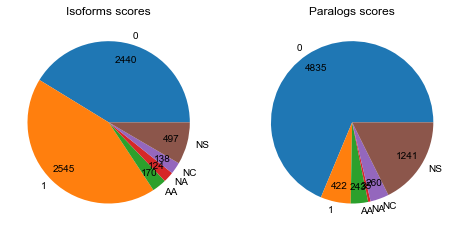

In [57]:
# do we find PPIs for every pair?


fig, axs = plt.subplots(1, 2)
fig.set_size_inches(8, 4)

counts = y2h.loc[(y2h['category'] == 'tf_isoform_ppis'), 'score'].value_counts().sort_index()

def absolute_value(val):
    return int(np.round(val / 100. * counts.sum(), 0))

counts.plot.pie(autopct=absolute_value, ax=axs[0],
                pctdistance=0.8)

counts = y2h.loc[y2h['category'].isin(['tf_paralog_ppis', 'paralog_with_PDI', 'non_paralog_control']), 'score'].value_counts().sort_index()

def absolute_value(val):
    return int(np.round(val / 100. * counts.sum(), 0))

counts.plot.pie(autopct=absolute_value, ax=axs[1],
                pctdistance=0.8)

axs[0].set_title('Isoforms scores')
axs[1].set_title('Paralogs scores')
for ax in axs:
    ax.set_ylabel('')
plt.savefig('../../figures/Y2H_scores-by-experiment_pie.pdf',
            bbox_inches='tight')

In [38]:
y2h.loc[y2h['category'].isin(['tf_paralog_ppis', 'paralog_with_PDI', 'non_paralog_control']) &
        (y2h['score'] == '1'), 'ad_gene_symbol'].value_counts()

TCF12      105
TCF4        50
SOX6        44
REL         19
IKZF2       19
TFCP2       15
MEIS1       14
RFX4        11
ZBTB16      10
ZNF18        9
ZSCAN25      9
ESRRG        9
LHX9         8
ARNT2        8
SOX5         7
PKNOX1       7
MEIS2        7
ZNF263       6
PATZ1        6
NFIX         6
MEOX1        5
ZBTB18       4
HNF4A        4
ZNF397       4
ZBTB32       3
PBX1         2
TP53         2
ZNF24        2
FOS          2
KLF4         2
SMAD4        2
PPARG        2
TEAD3        2
STAT1        2
FOSB         1
ZNF232       1
RXRB         1
RARA         1
RXRG         1
GLIS2        1
GRHL3        1
ZSCAN21      1
HMBOX1       1
TP63         1
TEAD2        1
RARG         1
ZIC3         1
CREM         1
HOXA1        1
Name: ad_gene_symbol, dtype: int64

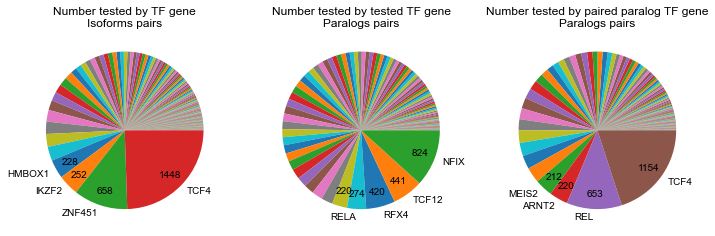

In [126]:
# pie chart by gene
# add another for matched gene for paralogs
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(12, 4)

counts = y2h.loc[(y2h['category'] == 'tf_isoform_ppis'), 'ad_gene_symbol'].value_counts().sort_values()

def absolute_value(val):
    s = int(np.round(val / 100. * counts.sum(), 0))
    if s >= 200:
        return s
    else:
        return ''

counts.plot.pie(autopct=absolute_value, ax=axs[0],
                pctdistance=0.8,
                labels=[i if i in counts.index[-4:] else '' for i in counts.index ],)

counts = y2h.loc[y2h['category'].isin(['tf_paralog_ppis', 'paralog_with_PDI', 'non_paralog_control']), 'ad_gene_symbol'].value_counts().sort_values()

def absolute_value(val):
    s = int(np.round(val / 100. * counts.sum(), 0))
    if s >= 200:
        return s
    else:
        return ''


counts.plot.pie(autopct=absolute_value, ax=axs[1],
                labels=[i if i in counts.index[-4:] else '' for i in counts.index ],
                pctdistance=0.8)

counts = y2h_paralog.loc[:, 'paired_tf_gene'].value_counts().sort_values()

def absolute_value(val):
    s = int(np.round(val / 100. * counts.sum(), 0))
    if s >= 200:
        return s
    else:
        return ''

counts.plot.pie(autopct=absolute_value, ax=axs[2],
                labels=[i if i in counts.index[-4:] else '' for i in counts.index ],
                pctdistance=0.8)

axs[0].set_title('Number tested by TF gene\nIsoforms pairs')
axs[1].set_title('Number tested by tested TF gene\nParalogs pairs')
axs[2].set_title('Number tested by paired paralog TF gene\nParalogs pairs')
for ax in axs:
    ax.set_ylabel('')
plt.savefig('../../figures/Y2H_N-PPIs-tested-by-TF-gene_pie.pdf',
            bbox_inches='tight')

In [165]:
valid_clones.groupby('gene').size().value_counts().sort_index()

1     63
2    136
3     60
4     30
5      9
6      8
7      2
8      2
dtype: int64

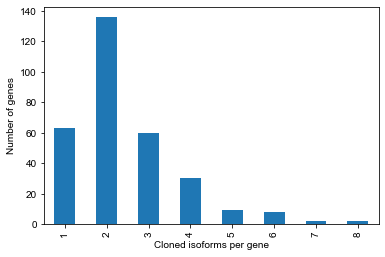

In [166]:
valid_clones.groupby('gene').size().value_counts().sort_index().plot.bar()
plt.ylabel('Number of genes')
plt.xlabel('Cloned isoforms per gene')
plt.savefig('../../figures/n-cloned-isoforms-per-gene_bar.pdf',
            bbox_inches='tight')

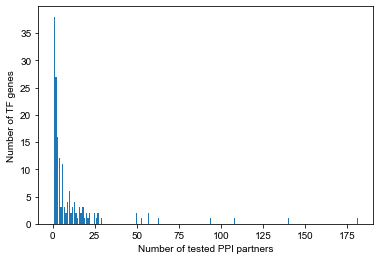

In [174]:
# look at Y2H degree of each gene
fig, ax = plt.subplots(1, 1)
vals = y2h.loc[y2h['category'] == 'tf_isoform_ppis', :].groupby('ad_gene_symbol')['db_gene_symbol'].nunique().value_counts().sort_index()
ax.bar(vals.index, vals.values)
ax.set_ylabel('Number of TF genes')
ax.set_xlabel('Number of tested PPI partners')
plt.savefig('../../figures/n-ppi-partners-per-tf-gene_bar.pdf',
            bbox_inches='tight')

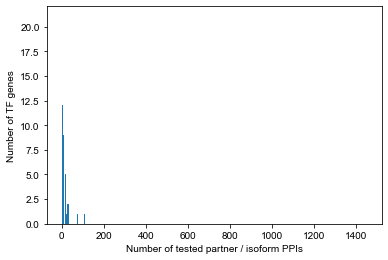

In [177]:
fig, ax = plt.subplots(1, 1)
vals = y2h.loc[y2h['category'] == 'tf_isoform_ppis', :].groupby('ad_gene_symbol').size().value_counts().sort_index()
ax.bar(vals.index, vals.values)
ax.set_ylabel('Number of TF genes')
ax.set_xlabel('Number of tested partner / isoform PPIs')
ax.set_ylim()
plt.savefig('../../figures/n-ppi-combinations-per-tf-gene_bar.pdf',
            bbox_inches='tight')

In [190]:
y2h.loc[y2h['category'] == 'tf_isoform_ppis', :].groupby('ad_gene_symbol').size().sort_values(ascending=False).to_frame().rename(columns={0: 'Number of tested partner/isoform PPIs'}).head(10)

,Number of tested partner/isoform PPIs
ad_gene_symbol,
TCF4,1448
ZNF451,658
IKZF2,252
HMBOX1,228
MEOX1,171
SOX6,156
TCF12,150
REL,140
ZBTB44,120


In [193]:
(y2h.loc[y2h['category'] == 'tf_isoform_ppis', :].groupby('ad_gene_symbol').size() <= 12).value_counts()

True     99
False    65
dtype: int64

In [198]:
y2h.loc[(y2h['ad_gene_symbol'] == 'TCF4') &
        (y2h['category'].isin(['tf_paralog_ppis', 'paralog_with_PDI', 'non_paralog_control'])), :].groupby('ad_clone_acc')['score'].value_counts()

ad_clone_acc    score
TCF4|1/9|07E01  1         9
                NS        4
                0         3
                NC        2
TCF4|2/9|07E03  1         9
                0         5
                NC        3
                NS        1
TCF4|3/9|07C04  1         7
                0         6
                NS        4
                NC        1
TCF4|4/9|07G02  0         9
                1         8
                NS        1
TCF4|5/9|07C02  0        10
                1         5
                NC        3
TCF4|6/9|07H03  0        15
                1         3
TCF4|7/9|07G03  0        12
                1         4
                AA        1
                NS        1
TCF4|8/9|07A05  0        13
                1         5
Name: score, dtype: int64

In [200]:
y2h.loc[(y2h['category'].isin(['tf_paralog_ppis', 'paralog_with_PDI', 'non_paralog_control']))
        & (y2h['score'] == '1'),
        'ad_clone_acc'].value_counts().head(10)

TCF12|1/3|07D07     67
TCF12|2/3|07A09     35
IKZF2|1/4|02B07     19
REL|1/2|12D03       19
TFCP2|1/3|03E08     15
MEIS1|1/2|09A04     14
SOX6|1/7|07C06      13
SOX6|2/7|07E06      13
SOX6|6/7|07F08      13
ZBTB16|1/2|01C03     9
Name: ad_clone_acc, dtype: int64

In [215]:
tfs = y2h.loc[(y2h['category'].isin(['tf_paralog_ppis', 'paralog_with_PDI', 'non_paralog_control']))
        & (y2h['score'] == '1'),
        'ad_clone_acc'].value_counts()
tfs = tfs.to_frame().rename(columns={'ad_clone_acc': 'n_positive'})
tfs['n_tested']  = y2h.loc[(y2h['category'].isin(['tf_paralog_ppis', 'paralog_with_PDI', 'non_paralog_control']))
        & y2h['score'].isin(['1', '0']),
        'ad_clone_acc'].value_counts()
tfs['rate'] = tfs['n_positive'] / tfs['n_tested']
tfs.sort_values('rate', ascending=False).head(20)

,n_positive,n_tested,rate
CREM|1/3|09D12,1,1,1.000000
SOX6|1/7|07C06,13,13,1.000000
SOX6|7/7|07C07,3,3,1.000000
SOX6|5/7|07A07,2,2,1.000000
SOX6|6/7|07F08,13,13,1.000000
SOX6|2/7|07E06,13,13,1.000000
ZIC3|2/3|12F04,1,1,1.000000
MEIS1|1/2|09A04,14,18,0.777778
TCF4|1/9|07E01,9,12,0.750000
IKZF2|1/4|02B07,19,26,0.730769


In [217]:
tfs.loc[tfs.index.str.startswith('TCF4')].sort_index()

,n_positive,n_tested,rate
TCF4|1/9|07E01,9,12,0.750000
TCF4|2/9|07E03,9,14,0.642857
TCF4|3/9|07C04,7,13,0.538462
TCF4|4/9|07G02,8,17,0.470588
TCF4|5/9|07C02,5,15,0.333333
TCF4|6/9|07H03,3,18,0.166667
TCF4|7/9|07G03,4,16,0.250000
TCF4|8/9|07A05,5,18,0.277778


,category,ad_orf_id,ad_clone_acc,ad_gene_symbol,db_orf_id,db_gene_symbol,score,standard_batch,retest_pla,retest_pos,in_orfeome_screen,in_focussed_screen,in_hi_union,in_lit_bm
0,rrs_isoforms,100303,E2F3|2/4|10A08,E2F3,5808,HBB,0,TFr11,1,F01,False,False,False,False
1,tf_isoform_ppis,100588,PRRX1|3/3|09H08,PRRX1,10057,HOXA1,NC,TFr11,1,E02,False,True,False,False
2,tf_isoform_ppis,101431,RFX4|3/3|12B07,RFX4,10057,HOXA1,NC,TFr11,1,D02,False,True,False,False
3,tf_isoform_ppis,100313,TCF4|8/9|07A05,TCF4,10057,HOXA1,NC,TFr11,1,C02,False,True,False,False
4,tf_isoform_ppis,101026,ZBTB16|2/2|01D03,ZBTB16,10057,HOXA1,NC,TFr11,1,B02,False,True,True,False
